<a href="https://colab.research.google.com/github/dvishnuvardhan21/Data-warehouse/blob/main/DW_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tweepy as tw #for scrapping data from witter using API
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import networkx as nx #for networking diagrams

from textblob import TextBlob #for polarity and subjectivity classification
import re
from wordcloud import WordCloud #for building wordcloud

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
stemmer=PorterStemmer()
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, auc, confusion_matrix

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
search_term = "lockdown"
date_since = "2020-11-12"
date_upto = "2020-11-13"

# Text Preprocessing

In [4]:
data = pd.read_csv("data.csv")
df = data[['tweet']]

In [5]:
#preprocessing of text
def preprocess_text(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)# Remove words with non-ASCII characters
    tweet = re.sub(r'@[A-Z0-9a-z_:]+','',tweet)#replace username-tags
    tweet = re.sub('#', '', tweet)
    tweet = re.sub(r'[^\w\s]', '',tweet)
    tweet = re.sub(r'[0-9]+', '', tweet)
    #tweet = re.sub('.', '', tweet)
    tweet = re.sub('rt', ' ', tweet)
    tweet = re.sub(r'^[RT]+','',tweet)#replace RT-tags
    tweet = re.sub('https?://[A-Za-z0-9./]+','',tweet)#replace URLs
    tweet = tweet.split()
    tweet = [stemmer.stem(word) for word in tweet if word not in set(stopwords.words('english'))] # Remove stop words
    tweet = " ".join(tweet)
    return tweet

In [6]:
df['text_clean'] = df.tweet.apply(preprocess_text)
df.head(3)

<ipython-input-6-60c3c39b9912>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_clean'] = df.tweet.apply(preprocess_text)


,tweet,text_clean
0,@dbseymour Jacinda is slowly transitioning us ...,jacinda slowli transit us capit social everi l...
1,Singapore Circuit Breaker – Using qmdj to For...,singapor circuit breaker use qmdj forecast out...
2,RT @YuriLowenthal: Suicide figures are up 200%...,suicid figur sinc lockdown could friend pleas ...


## Polarity and Subjectivity

In [7]:
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

def getanalysis(score):
    if score < 0:
      return '-1'
    elif score == 0:
      return '0'
    else:
      return '1'

df['polarity'] = df['text_clean'].apply(getPolarity)

df['label'] = df['polarity'].apply(getanalysis)

<ipython-input-7-8856c7d808e7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polarity'] = df['text_clean'].apply(getPolarity)
<ipython-input-7-8856c7d808e7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['polarity'].apply(getanalysis)


In [8]:
#df['text'] = [word for word in df['text_clean'] if word not in set(stopwords.words('english'))] # Remove stop words

In [9]:
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity


def spellcheck(text):
    return TextBlob(text).correct()

#df['text'] = df['text'].apply(spellcheck)

df['text_token'] = df['text_clean'].apply(lambda x: word_tokenize(x))

stemming = PorterStemmer()
df['text_stemmed'] = df['text_token'].apply(lambda x: " ".join([stemming.stem(i) for i in x]))

lemmatizing = WordNetLemmatizer()
df['text_lemmatized'] = df['text_token'].apply(lambda x: " ".join([lemmatizing.lemmatize(i) for i in x]))
# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df.head(3)

# Create two new columns 'Subjectivity' & 'Polarity'
df['subjectivity'] = df['text_clean'].apply(getSubjectivity)

<ipython-input-9-3753a3a5feee>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_token'] = df['text_clean'].apply(lambda x: word_tokenize(x))
<ipython-input-9-3753a3a5feee>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_stemmed'] = df['text_token'].apply(lambda x: " ".join([stemming.stem(i) for i in x]))
<ipython-input-9-3753a3a5feee>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

# EDA

In [10]:
df[['tweet','text_clean','text_stemmed', 'text_lemmatized' ,'polarity', 'label']].head()

,tweet,text_clean,text_stemmed,text_lemmatized,polarity,label
0,@dbseymour Jacinda is slowly transitioning us ...,jacinda slowli transit us capit social everi l...,jacinda slowli transit us capit social everi l...,jacinda slowli transit u capit social everi lo...,0.033333,1
1,Singapore Circuit Breaker – Using qmdj to For...,singapor circuit breaker use qmdj forecast out...,singapor circuit breaker use qmdj forecast out...,singapor circuit breaker use qmdj forecast out...,0.000000,0
2,RT @YuriLowenthal: Suicide figures are up 200%...,suicid figur sinc lockdown could friend pleas ...,suicid figur sinc lockdown could friend plea c...,suicid figur sinc lockdown could friend plea c...,0.000000,0
3,RT @YuriLowenthal: Suicide figures are up 200%...,suicid figur sinc lockdown could friend pleas ...,suicid figur sinc lockdown could friend plea c...,suicid figur sinc lockdown could friend plea c...,0.000000,0
4,@Brent_Thoma @CitizenHalton @PremierScottMoe I...,make choic melbourn back jul httpstconezngpcf,make choic melbourn back jul httpstconezngpcf,make choic melbourn back jul httpstconezngpcf,0.000000,0


In [11]:
words = df['text_token']
words[0]

['jacinda',
 'slowli',
 'transit',
 'us',
 'capit',
 'social',
 'everi',
 'lockdown',
 'becom',
 'mor',
 'httpstcoavioiazxij']

## Most Common Words

In [12]:
#all words in all tweets
all_words = list(itertools.chain(*words))

count_words = collections.Counter(all_words)

count_words.most_common(15)

[('lockdown', 26018),
 ('suicid', 10638),
 ('could', 10498),
 ('sinc', 10497),
 ('figur', 9521),
 ('pleas', 9506),
 ('tweet', 9202),
 ('copi', 9135),
 ('repost', 9064),
 ('tri', 8729),
 ('friend', 8126),
 ('covid', 3730),
 ('dem', 3137),
 ('demonstr', 2259),
 ('peopl', 2017)]

In [13]:
df_count_words = pd.DataFrame(count_words.most_common(15), columns=['word', 'count'])
df_count_words

,word,count
0,lockdown,26018
1,suicid,10638
2,could,10498
3,sinc,10497
4,figur,9521
5,pleas,9506
6,tweet,9202
7,copi,9135
8,repost,9064
9,tri,8729


### Histogram of most common words

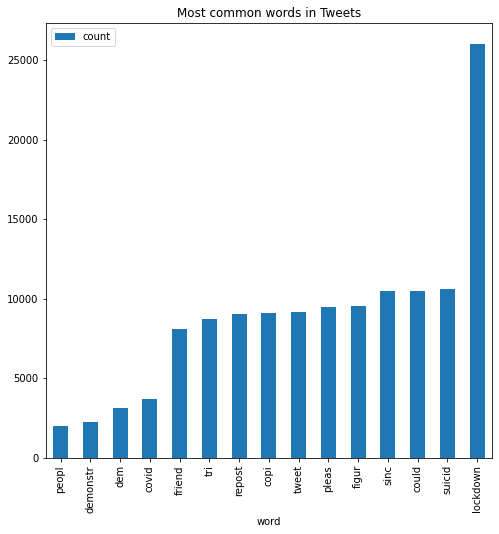

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
df_count_words.sort_values(by='count').plot.bar(x='word', y='count',
                                               ax=ax)
ax.set_title("Most common words in Tweets")
plt.show()

## Bi-grams

In [15]:
for text in all_words:
    token = nltk.word_tokenize(text)
    bigram = list(ngrams(token, 2))

### Most common Bi-grams

In [16]:
six = ngrams(all_words, 2)
six_count = collections.Counter(six)
df_bigram = pd.DataFrame(six_count.most_common(20), columns=['bigram', 'count'])
df_bigram

,bigram,count
0,"(sinc, lockdown)",10045
1,"(suicid, figur)",9353
2,"(figur, sinc)",9277
3,"(lockdown, could)",9259
4,"(pleas, copi)",9076
5,"(copi, repost)",9032
6,"(repost, tweet)",8997
7,"(tweet, tri)",8478
8,"(could, friend)",7905
9,"(friend, pleas)",7639


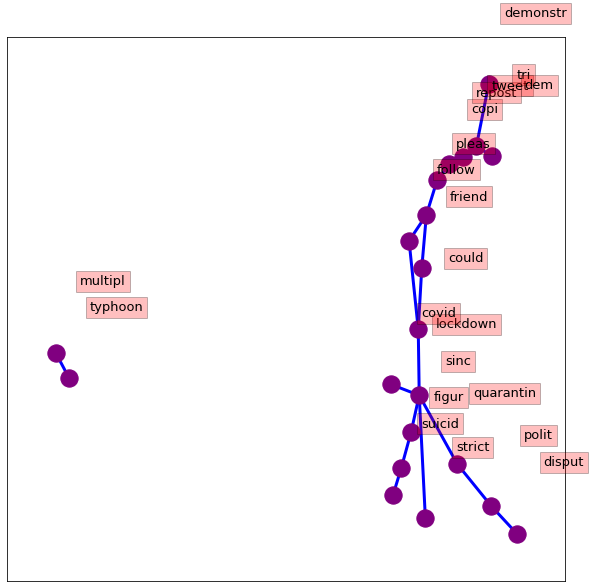

In [17]:
d = df_bigram.set_index('bigram').T.to_dict('records')

G = nx.Graph()

for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v*10))
G.add_node("lockdown", weight=100)

fig, ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx(G, pos, font_size=15, width=3, edge_color='blue',
                node_color='purple', with_labels=False, ax=ax)

for key, value in pos.items():
    x,y = value[0]+0.135, value[1]+0.045
    ax.text(x,y, s=key, bbox=dict(facecolor='red', alpha=0.25),
           horizontalalignment='center', fontsize=13)

### Network of Bi-grams

In [18]:
six = ngrams(all_words, 3)
six_count = collections.Counter(six)
df_trigram = pd.DataFrame(six_count.most_common(20), columns=['trigram', 'count'])
df_trigram

,trigram,count
0,"(suicid, figur, sinc)",9275
1,"(figur, sinc, lockdown)",9218
2,"(sinc, lockdown, could)",9050
3,"(pleas, copi, repost)",9018
4,"(copi, repost, tweet)",8972
5,"(repost, tweet, tri)",8475
6,"(friend, pleas, copi)",7598
7,"(could, friend, pleas)",7593
8,"(lockdown, could, friend)",7583
9,"(tweet, tri, dem)",3086


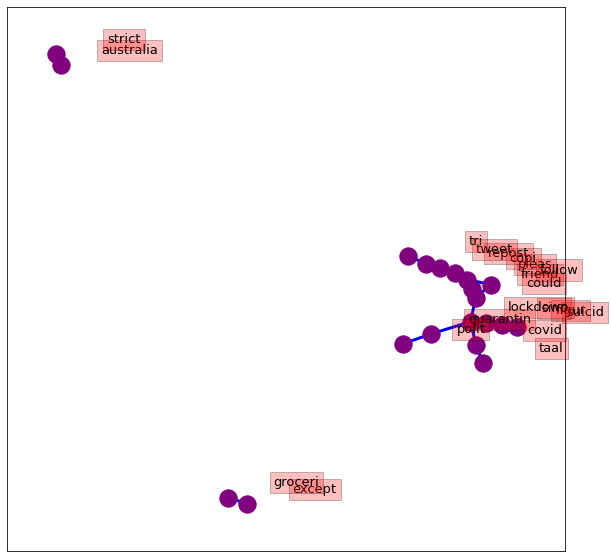

In [19]:
d = df_trigram.set_index('trigram').T.to_dict('records')

G = nx.Graph()

for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v*10))
G.add_node("lockdown", weight=100)

fig, ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx(G, pos, font_size=15, width=3, edge_color='blue',
                node_color='purple', with_labels=False, ax=ax)

for key, value in pos.items():
    x,y = value[0]+0.135, value[1]+0.045
    ax.text(x,y, s=key, bbox=dict(facecolor='red', alpha=0.25),
           horizontalalignment='center', fontsize=13)

## Polarity Histogram

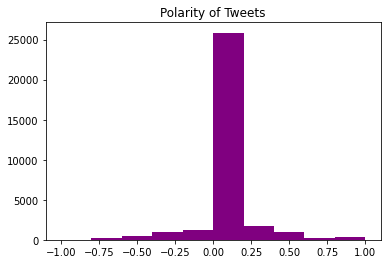

In [20]:
df['polarity'].hist(color='purple')
plt.grid(False)
plt.title("Polarity of Tweets")
plt.show()

# Polarity(labels) Histogram

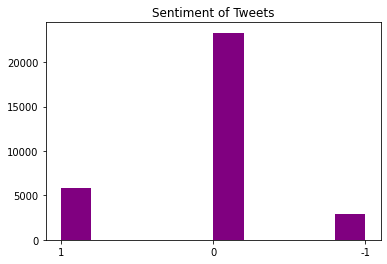

In [21]:
df['label'].hist(color='purple')
plt.grid(False)
plt.title("Sentiment of Tweets")
plt.show()

## Subjectivity Histogram

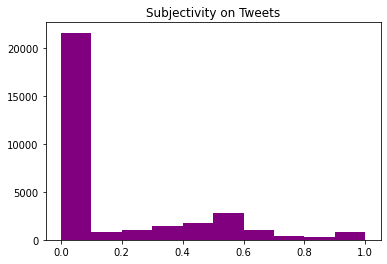

In [22]:
df['subjectivity'].hist(color='purple')
plt.grid(False)
plt.title("Subjectivity on Tweets")
plt.show()

In [23]:
df['label'].value_counts()

0     23307
1      5778
-1     2915
Name: label, dtype: int64

## Scatter Plot - Polarity vs Subjectivity

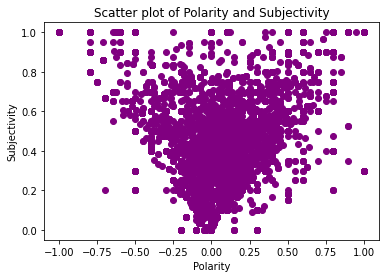

In [24]:
plt.scatter(df['polarity'], df['subjectivity'], color='purple')
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.title("Scatter plot of Polarity and Subjectivity")
plt.show()

## Wordcloud

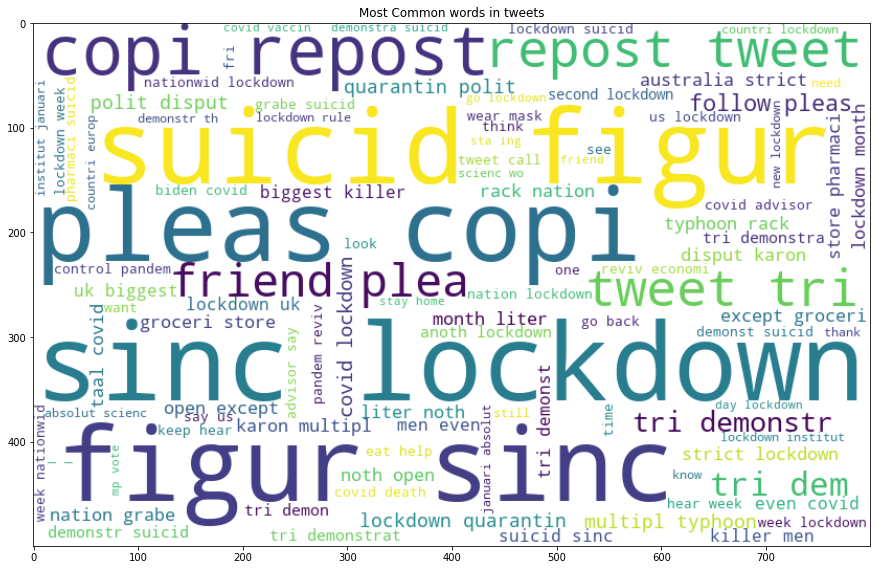

In [25]:
words = ' '.join([text for text in all_words])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, 
                      background_color='white',max_words=100, repeat=False).generate(words)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most Common words in tweets")
plt.show()

# Models 

## Train & Test Data

In [26]:
x = df.text_clean
y = df.label
xs = df.text_stemmed
xl = df.text_lemmatized

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=42)
xs_train, xs_test, ys_train, ys_test = train_test_split(xs,y, test_size = 0.3, random_state=42)
xl_train, xl_test, yl_train, yl_test = train_test_split(xl,y, test_size = 0.3, random_state=42)

In [28]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [29]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(lr, x, y, cv=10)
cv_score*100, cv_score.mean()*100

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1508, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.8/dist-packages/skl

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), nan)

## Multinominal Navie Bayes

In [30]:
y1 = y_test.copy()

In [31]:
y_test.value_counts()

0     6972
1     1757
-1     871
Name: label, dtype: int64

accuracy = 90.35416666666667
Confusion matrix 
 [[ 408  308  155]
 [   2 6797  173]
 [   1  287 1469]]
Classification Report with text: 
               precision    recall  f1-score   support

    negative       0.99      0.47      0.64       871
     neutral       0.92      0.97      0.95      6972
    positive       0.82      0.84      0.83      1757

    accuracy                           0.90      9600
   macro avg       0.91      0.76      0.80      9600
weighted avg       0.91      0.90      0.90      9600



Text(33.0, 0.5, 'True')

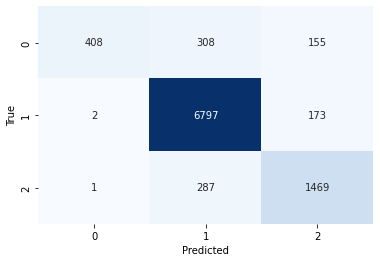

In [32]:
#Navie Bayes MutltinomialNB
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())])
nb.fit(x_train, y_train)

label=['negative', 'neutral','positive']
y_pred = nb.predict(x_test)
acc_nb = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_nb)
cm_nb = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_nb)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report with text: \n", clfr) 
sns.heatmap(cm_nb,annot=True, fmt="d",cmap="Blues",cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

accuracy = 90.26041666666667
Confusion matrix 
 [[ 403  310  158]
 [   2 6793  177]
 [   1  287 1469]]
Classification Report with text_stemmed: 
               precision    recall  f1-score   support

    negative       0.99      0.46      0.63       871
     neutral       0.92      0.97      0.95      6972
    positive       0.81      0.84      0.83      1757

    accuracy                           0.90      9600
   macro avg       0.91      0.76      0.80      9600
weighted avg       0.91      0.90      0.90      9600



Text(33.0, 0.5, 'True')

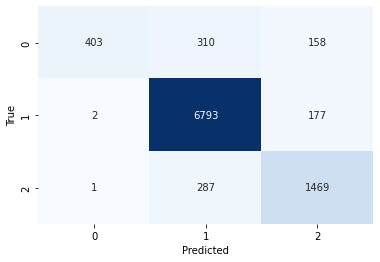

In [33]:
nb.fit(xs_train, ys_train)
label=['negative', 'neutral','positive']
ys_pred = nb.predict(xs_test)
acc_nbs = accuracy_score(ys_pred, ys_test)*100
print("accuracy =", acc_nbs)
cm_nbs = confusion_matrix(ys_test, ys_pred)
print("Confusion matrix \n", cm_nbs)
clfr = metrics.classification_report(ys_test, ys_pred, target_names=label)
print("Classification Report with text_stemmed: \n", clfr) 
sns.heatmap(cm_nbs,annot=True, fmt="d",cmap="Blues",cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

accuracy = 90.3125
Confusion matrix 
 [[ 408  310  153]
 [   2 6790  180]
 [   1  284 1472]]
Classification Report with text_lemmetised: 
               precision    recall  f1-score   support

    negative       0.99      0.47      0.64       871
     neutral       0.92      0.97      0.95      6972
    positive       0.82      0.84      0.83      1757

    accuracy                           0.90      9600
   macro avg       0.91      0.76      0.80      9600
weighted avg       0.91      0.90      0.90      9600



Text(33.0, 0.5, 'True')

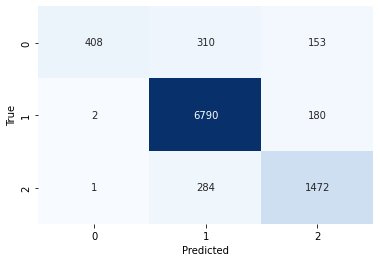

In [34]:
nb.fit(xl_train, y_train)

label=['negative', 'neutral','positive']
y_pred = nb.predict(xl_test)
acc_nbl = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_nbl)
cm_nbl = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_nbl)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report with text_lemmetised: \n", clfr) 
sns.heatmap(cm_nbl,annot=True, fmt="d",cmap="Blues",cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

## Logistic Regression

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy = 95.94791666666667
Confusion matrix 
 [[ 646  179   46]
 [   3 6961    8]
 [  10  143 1604]]
Classification Report with text: 
               precision    recall  f1-score   support

    negative       0.98      0.74      0.84       871
     neutral       0.96      1.00      0.98      6972
    positive       0.97      0.91      0.94      1757

    accuracy                           0.96      9600
   macro avg       0.97      0.88      0.92      9600
weighted avg       0.96      0.96      0.96      9600



Text(33.0, 0.5, 'True')

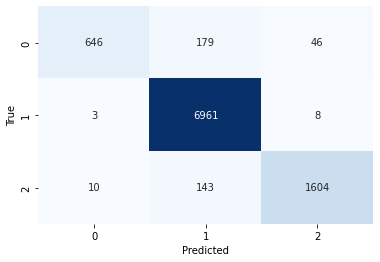

In [35]:
#Logistic regression
lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression())])
lr.fit(x_train, y_train)

label=['negative', 'neutral','positive']
y_pred = lr.predict(x_test)
acc_lr = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_lr)
cm_lr = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_lr)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report with text: \n", clfr) 
sns.heatmap(cm_lr,annot=True, fmt="d",cmap="Blues",cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy = 95.91666666666666
Confusion matrix 
 [[ 643  182   46]
 [   3 6961    8]
 [  11  142 1604]]
Classification Report with text_stemmed: 
               precision    recall  f1-score   support

    negative       0.98      0.74      0.84       871
     neutral       0.96      1.00      0.98      6972
    positive       0.97      0.91      0.94      1757

    accuracy                           0.96      9600
   macro avg       0.97      0.88      0.92      9600
weighted avg       0.96      0.96      0.96      9600



Text(33.0, 0.5, 'True')

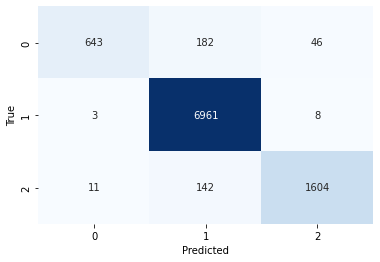

In [36]:
lr.fit(xs_train, y_train)
label=['negative', 'neutral','positive']
y_pred = lr.predict(xs_test)
acc_lrs = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_lrs)
cm_lrs = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_lrs)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report with text_stemmed: \n", clfr) 
sns.heatmap(cm_lrs,annot=True, fmt="d",cmap="Blues",cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy = 95.91666666666666
Confusion matrix 
 [[ 644  180   47]
 [   3 6961    8]
 [  11  143 1603]]
Classification Report with text_lemmatized: 
               precision    recall  f1-score   support

    negative       0.98      0.74      0.84       871
     neutral       0.96      1.00      0.98      6972
    positive       0.97      0.91      0.94      1757

    accuracy                           0.96      9600
   macro avg       0.97      0.88      0.92      9600
weighted avg       0.96      0.96      0.96      9600



Text(33.0, 0.5, 'True')

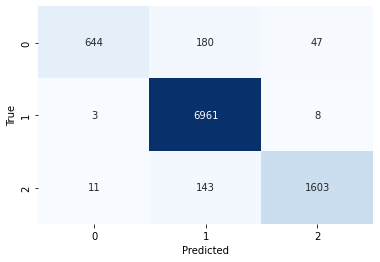

In [37]:
lr.fit(xl_train, y_train)
label=['negative', 'neutral','positive']
y_pred = lr.predict(xl_test)
acc_lrl = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_lrl)
cm_lrl = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_lrl)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report with text_lemmatized: \n", clfr) 
sns.heatmap(cm_lrl,annot=True, fmt="d",cmap="Blues",cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

## Linear SVM (SGD)

accuracy = 96.53125
Confusion matrix 
 [[ 695  135   41]
 [   3 6962    7]
 [  12  135 1610]]
Classification Report: SGD Classifier with text 
               precision    recall  f1-score   support

    negative       0.98      0.80      0.88       871
     neutral       0.96      1.00      0.98      6972
    positive       0.97      0.92      0.94      1757

    accuracy                           0.97      9600
   macro avg       0.97      0.90      0.93      9600
weighted avg       0.97      0.97      0.96      9600



Text(33.0, 0.5, 'True')

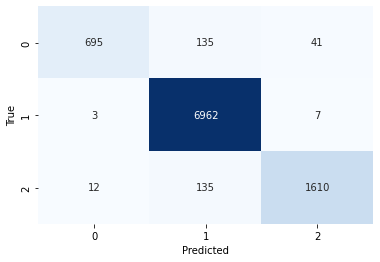

In [38]:
#Linear Support Vector Machines
sgd = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier())])
sgd.fit(x_train, y_train)

label=['negative', 'neutral','positive']
y_pred = sgd.predict(x_test)
acc_sgd = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_sgd)
cm_sgd = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_sgd)
label=['negative', 'neutral','positive']
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: SGD Classifier with text \n", clfr) 
sns.heatmap(cm_sgd, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

accuracy = 96.4375
Confusion matrix 
 [[ 688  143   40]
 [   4 6962    6]
 [  13  136 1608]]
Classification Report with text_stemmed: 
               precision    recall  f1-score   support

    negative       0.98      0.79      0.87       871
     neutral       0.96      1.00      0.98      6972
    positive       0.97      0.92      0.94      1757

    accuracy                           0.96      9600
   macro avg       0.97      0.90      0.93      9600
weighted avg       0.96      0.96      0.96      9600



Text(33.0, 0.5, 'True')

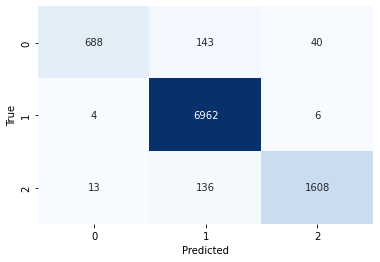

In [39]:
sgd.fit(xs_train, y_train)
label=['negative', 'neutral','positive']
y_pred = sgd.predict(xs_test)
acc_sgds = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_sgds)
cm_sgds = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_sgds)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report with text_stemmed: \n", clfr) 
sns.heatmap(cm_sgds, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

accuracy = 96.44791666666667
Classification Report: SGD Classifier with text_lemmatized 
               precision    recall  f1-score   support

    negative       0.97      0.79      0.87       871
     neutral       0.96      1.00      0.98      6972
    positive       0.97      0.92      0.94      1757

    accuracy                           0.96      9600
   macro avg       0.97      0.90      0.93      9600
weighted avg       0.96      0.96      0.96      9600



Text(33.0, 0.5, 'True')

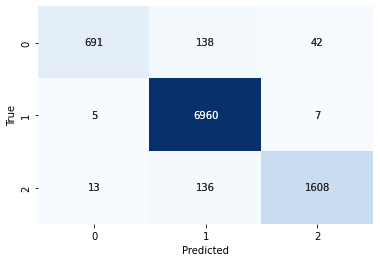

In [40]:
sgd.fit(xl_train, y_train)
label=['negative', 'neutral','positive']
y_pred = sgd.predict(xl_test)
acc_sgdl = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_sgdl)
cm_sgdl = confusion_matrix(y_test, y_pred)
 

label=['negative', 'neutral','positive']
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: SGD Classifier with text_lemmatized \n", clfr) 
sns.heatmap(cm_sgdl, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(cm_sgdl, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

## Random Forest

accuracy = 97.64583333333333
Confusion matrix 
 [[ 740   89   42]
 [   4 6962    6]
 [  14   71 1672]]
Classification Report with text: 
               precision    recall  f1-score   support

    negative       0.98      0.85      0.91       871
     neutral       0.98      1.00      0.99      6972
    positive       0.97      0.95      0.96      1757

    accuracy                           0.98      9600
   macro avg       0.98      0.93      0.95      9600
weighted avg       0.98      0.98      0.98      9600



Text(33.0, 0.5, 'True')

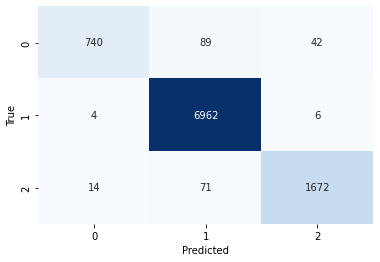

In [41]:
#Random Forest
rfc = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier())])
rfc.fit(x_train, y_train)

label=['negative', 'neutral','positive']
y_pred = rfc.predict(x_test)
acc_rfc = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_rfc)
cm_rfc = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_rfc)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report with text: \n", clfr) 
sns.heatmap(cm_rfc, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

accuracy = 97.77083333333333
Confusion matrix 
 [[ 746   81   44]
 [   1 6963    8]
 [  11   69 1677]]
Classification Report: Random Forest with text_stemmed: 
               precision    recall  f1-score   support

    negative       0.98      0.86      0.92       871
     neutral       0.98      1.00      0.99      6972
    positive       0.97      0.95      0.96      1757

    accuracy                           0.98      9600
   macro avg       0.98      0.94      0.96      9600
weighted avg       0.98      0.98      0.98      9600



Text(33.0, 0.5, 'True')

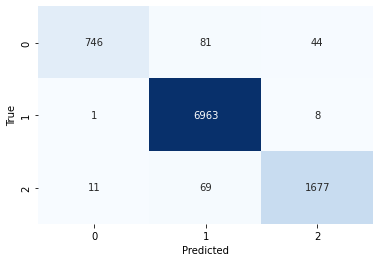

In [42]:
rfc.fit(xs_train, y_train)
label=['negative', 'neutral','positive']
y_pred = rfc.predict(xs_test)
acc_rfcs = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_rfcs)
cm_rfcs = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_rfcs)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: Random Forest with text_stemmed: \n", clfr) 
sns.heatmap(cm_rfcs, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

accuracy = 97.58333333333333
Confusion matrix 
 [[ 743   87   41]
 [   1 6963    8]
 [  14   81 1662]]
Classification Report: Random Forest with text_lemmatized: 
               precision    recall  f1-score   support

    negative       0.98      0.85      0.91       871
     neutral       0.98      1.00      0.99      6972
    positive       0.97      0.95      0.96      1757

    accuracy                           0.98      9600
   macro avg       0.98      0.93      0.95      9600
weighted avg       0.98      0.98      0.98      9600



Text(33.0, 0.5, 'True')

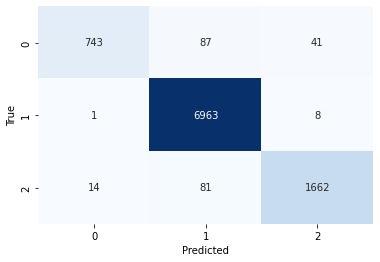

In [43]:
rfc.fit(xl_train, y_train)
label=['negative', 'neutral','positive']
y_pred = rfc.predict(xl_test)
acc_rfcl = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_rfcl)
cm_rfcl = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_rfcl)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: Random Forest with text_lemmatized: \n", clfr) 
sns.heatmap(cm_rfcl, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

## Bagging Classifier

accuracy = 97.45833333333334
Confusion matrix 
 [[ 758   71   42]
 [   8 6957    7]
 [  25   91 1641]]
Classification Report: Bagging Classifier with text 
               precision    recall  f1-score   support

    negative       0.96      0.87      0.91       871
     neutral       0.98      1.00      0.99      6972
    positive       0.97      0.93      0.95      1757

    accuracy                           0.97      9600
   macro avg       0.97      0.93      0.95      9600
weighted avg       0.97      0.97      0.97      9600



Text(33.0, 0.5, 'True')

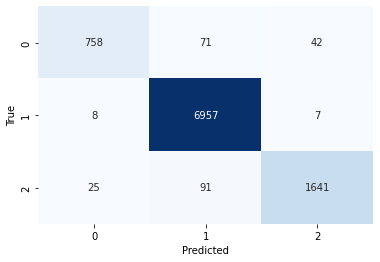

In [44]:
#Bagging Classifier
bag = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', BaggingClassifier())])
bag.fit(x_train, y_train)

label=['negative', 'neutral','positive']
y_pred = bag.predict(x_test)
acc_bag = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_bag)
cm_bag = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_bag)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: Bagging Classifier with text \n", clfr) 
label=['negative', 'neutral','positive']
sns.heatmap(cm_bag, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

accuracy = 97.45833333333334
Confusion matrix 
 [[ 764   68   39]
 [  14 6953    5]
 [  33   85 1639]]
Classification Report with text_stemmed: 
               precision    recall  f1-score   support

    negative       0.94      0.88      0.91       871
     neutral       0.98      1.00      0.99      6972
    positive       0.97      0.93      0.95      1757

    accuracy                           0.97      9600
   macro avg       0.96      0.94      0.95      9600
weighted avg       0.97      0.97      0.97      9600



Text(33.0, 0.5, 'True')

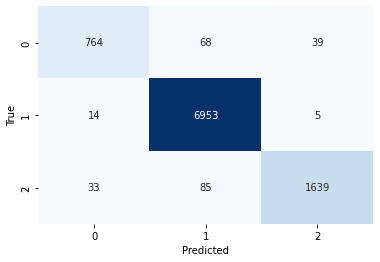

In [45]:
bag.fit(xs_train, y_train)
label=['negative', 'neutral','positive']
y_pred = bag.predict(xs_test)
acc_bags = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_bags)
cm_bags = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_bags)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report with text_stemmed: \n", clfr) 
sns.heatmap(cm_bags, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

accuracy = 97.70833333333333
Confusion matrix 
 [[ 774   57   40]
 [   6 6959    7]
 [  31   79 1647]]
Classification Report: Bagging Classifier with text_lemmatized
               precision    recall  f1-score   support

    negative       0.95      0.89      0.92       871
     neutral       0.98      1.00      0.99      6972
    positive       0.97      0.94      0.95      1757

    accuracy                           0.98      9600
   macro avg       0.97      0.94      0.95      9600
weighted avg       0.98      0.98      0.98      9600



Text(33.0, 0.5, 'True')

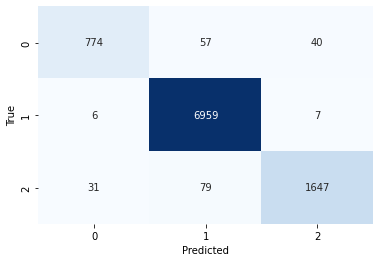

In [46]:
bag.fit(xl_train, y_train)
label=['negative', 'neutral','positive']
y_pred = bag.predict(xl_test)
acc_bagl = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_bagl)
cm_bagl = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_bagl)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: Bagging Classifier with text_lemmatized\n", clfr) 
label=['negative', 'neutral','positive']
sns.heatmap(cm_bagl, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

## Decision Tree

accuracy = 97.48958333333333
Confusion matrix 
 [[ 779   47   45]
 [  16 6927   29]
 [  34   70 1653]]
Classification Report with text: 
               precision    recall  f1-score   support

    negative       0.94      0.89      0.92       871
     neutral       0.98      0.99      0.99      6972
    positive       0.96      0.94      0.95      1757

    accuracy                           0.97      9600
   macro avg       0.96      0.94      0.95      9600
weighted avg       0.97      0.97      0.97      9600



Text(33.0, 0.5, 'True')

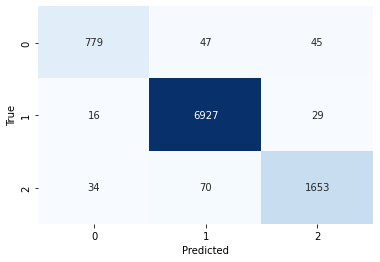

In [47]:
#Decision Trees
dt = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', DecisionTreeClassifier())])
dt.fit(x_train, y_train)

label=['negative', 'neutral','positive']
y_pred = dt.predict(x_test)
acc_dt = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_dt)
cm_dt = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_dt)
label=['negative', 'neutral','positive']
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report with text: \n", clfr) 
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

accuracy = 97.58333333333333
Confusion matrix 
 [[ 775   50   46]
 [  22 6939   11]
 [  39   64 1654]]
Classification Report with text_stemmed: 
               precision    recall  f1-score   support

    negative       0.93      0.89      0.91       871
     neutral       0.98      1.00      0.99      6972
    positive       0.97      0.94      0.95      1757

    accuracy                           0.98      9600
   macro avg       0.96      0.94      0.95      9600
weighted avg       0.98      0.98      0.98      9600



Text(33.0, 0.5, 'True')

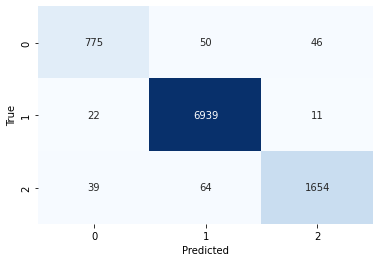

In [48]:
dt.fit(xs_train, y_train)
label=['negative', 'neutral','positive']
y_pred = dt.predict(xs_test)
acc_dts = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_dts)
cm_dts = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_dts)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report with text_stemmed: \n", clfr) 
sns.heatmap(cm_dts, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

accuracy = 97.51041666666667
Confusion matrix 
 [[ 780   48   43]
 [  22 6922   28]
 [  31   67 1659]]
Classification Report with text_lemmatized: 
               precision    recall  f1-score   support

    negative       0.94      0.90      0.92       871
     neutral       0.98      0.99      0.99      6972
    positive       0.96      0.94      0.95      1757

    accuracy                           0.98      9600
   macro avg       0.96      0.94      0.95      9600
weighted avg       0.97      0.98      0.97      9600



Text(33.0, 0.5, 'True')

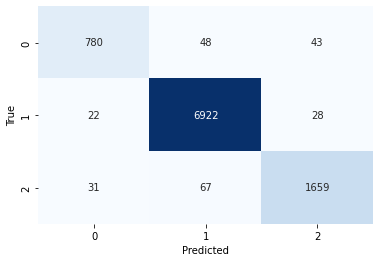

In [49]:
dt.fit(xl_train, y_train)
label=['negative', 'neutral','positive']
y_pred = dt.predict(xl_test)
acc_dtl = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_dtl)
cm_dtl = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_dtl)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report with text_lemmatized: \n", clfr) 
sns.heatmap(cm_dtl, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

# Conclusion

In [50]:
data = {'Classifiers': ['Multinomial NB', 'Logistic Regression', 'SGD Classifier', 'Random Forest Classifier', 
                        'Decision Tree Classifier', "Bagging Classifier"],
        'Accuracy': [acc_nb, acc_lr, acc_sgd, acc_rfc, acc_dt, acc_bag],
        "Accuracy_Stemmed":[acc_nbs,acc_lrs, acc_sgds, acc_rfcs,acc_dts, acc_bags],
        "Accuracy_Lemmatized":[acc_nbl,acc_lrl, acc_sgdl, acc_rfcl, acc_dtl,acc_bagl]}
Accuracies = pd.DataFrame(data=data)
Accuracies.set_index('Classifiers', inplace=True)
Accuracies

,Accuracy,Accuracy_Stemmed,Accuracy_Lemmatized
Classifiers,,,
Multinomial NB,90.354167,90.260417,90.312500
Logistic Regression,95.947917,95.916667,95.916667
SGD Classifier,96.531250,96.437500,96.447917
Random Forest Classifier,97.645833,97.770833,97.583333
Decision Tree Classifier,97.489583,97.583333,97.510417
Bagging Classifier,97.458333,97.458333,97.708333
